メモ：RMSDを比較することで、良い特徴量だけを選び出す。さらに、それらの良い特徴量だけで計算を行い、全部入りの計算結果と比較して性能差がどれくらいあるか調べる。性能差がそこまで変わらず、計算時間が減ったら嬉しい。

In [170]:
import pandas as pd
import pickle
import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import PandasTools
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem.rdchem import HybridizationType
import rdkit.Chem.AllChem as AllChem
import torch
import torch_geometric as pyg
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch_geometric.utils import one_hot, scatter
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Dataset, InMemoryDataset, download_url, extract_zip
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, NNConv
from torch_geometric.nn.conv import GATv2Conv, GATConv, TransformerConv
from torch_geometric.nn.models import MLP
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import one_hot, scatter
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import os
import os.path as osp
import pickle
import sys
import shutil
from typing import Callable, List, Optional

In [2]:
qm9csv = pd.read_csv("/home/higuchi/Pytorch/GCN/QM9/raw/gdb9.sdf.csv")
sdf = "/home/higuchi/Pytorch/GCN/QM9/raw/gdb9.sdf"
#mols = rdkit.Chem.SDMolSupplier(sdf, removeHs=False) #sdfからmolオブジェクトを生成
#mols = [m for m in mols if m is not None]
with open("mols_unprocessed", "rb") as f:
    mols = pickle.load(f)

# ETKDG Process (Mettya zikan kakaru...)
mols_ETKDG = []
mols_Hs = [rdkit.Chem.AddHs(mol) for mol in mols]
for mol in mols_Hs:
    ETKDG = AllChem.ETKDG()
    AllChem.EmbedMolecule(mol, ETKDG)
    mols_ETKDG.append(mol)

KeyboardInterrupt: 

In [4]:
# 3D structure generation with DeepChem (Hayai! approx. 2m)
import deepchem
featurizer = deepchem.feat.Mol2VecFingerprint()
mols_features = []
for mol in mols_Hs:
    features = featurizer.featurize(rdkit.Chem.MolToSmiles(mol))
    mols_features.append(features)

ModuleNotFoundError: No module named 'deepchem'

Setting:
layer=3, hidden_layer=64
epoch_num=100

In [163]:
#dataset_all = MyQM9(root="./")
shutil.rmtree("./QM9_reduced/processed/")
dataset_reduced = MyQM9(root="./QM9_reduced")

Processing...
100%|██████████| 133885/133885 [00:40<00:00, 3303.54it/s]
Done!


In [173]:
import random
random.choice(dataset_all).x

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.,

In [164]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, 32)
        self.linear1 = nn.Linear(16,1)
        self.out = nn.Linear(32, 1)
        #self.conv3 = GCNConv(32, dataset.num_classes) #num_classes:ラベルの数
    #バッチノルム(正則化)
    def forward(self, data):
        x, batch, edge_index, edge_attr = data.x, data.batch, data.edge_index, data.edge_attr
        # Dropout:一定割合のノードを不活性化(0になる)させ、過学習を緩和する。pはゼロになるノードの確率で、0.5がデフォルト。
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch_geometric.nn.global_add_pool(x, batch) #これが必要やった
        #x = F.dropout(x, p=0.2, training=self.training) # 取ってみる
        x = self.out(x)
        return x

class GCN_N(torch.nn.Module):
    def __init__(self, layer:int, dim=32, dataset=dataset):
        super().__init__()
        self.layer = layer
        self.dataset = dataset
        self.dim = dim
        self.conv1 = GCNConv(self.dataset.num_node_features, self.dim, improved=True)
        self.convn = GCNConv(self.dim, self.dim, improved=True)
        self.out = pyg.nn.Linear(self.dim, 1)

    def forward(self, data):
        x, batch, edge_index, edge_attr = data.x, data.batch, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        for i in range(2, self.layer + 1):
            x = self.convn(x, edge_index)
            x = F.relu(x)
        x = pyg.nn.global_add_pool(x, batch) 
        #x = F.dropout(x, p=0.2, training=self.training)
        x = self.out(x)
        return x

In [ ]:
HAR2EV = 27.211386246
KCALMOL2EV = 0.04336414

conversion = torch.tensor([
    1., 1., HAR2EV, HAR2EV, HAR2EV, 1., HAR2EV, HAR2EV, HAR2EV, HAR2EV, HAR2EV,
    1., KCALMOL2EV, KCALMOL2EV, KCALMOL2EV, KCALMOL2EV, 1., 1., 1.
])

atomrefs = {
    6: [0., 0., 0., 0., 0.],
    7: [
        -13.61312172, -1029.86312267, -1485.30251237, -2042.61123593,
        -2713.48485589
    ],
    8: [
        -13.5745904, -1029.82456413, -1485.26398105, -2042.5727046,
        -2713.44632457
    ],
    9: [
        -13.54887564, -1029.79887659, -1485.2382935, -2042.54701705,
        -2713.42063702
    ],
    10: [
        -13.90303183, -1030.25891228, -1485.71166277, -2043.01812778,
        -2713.88796536
    ],
    11: [0., 0., 0., 0., 0.],
}

#消す記述子の選択
descriptors = [atomic_number, aromatic, sp, sp2, sp3]
for desc in descriptors:
    descriptors = [atomic_number, aromatic, sp, sp2, sp3]
    descriptors.remove(desc)

    shutil.rmtree("./QM9_reduced/processed/")
    dataset_reduced = MyQM9(root="./QM9_reduced")

    class MyQM9(InMemoryDataset):
        def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, pre_reduced=None):
            super().__init__(root, transform, pre_transform, pre_filter)
            self.data, self.slices = torch.load(self.processed_paths[0])

        def mean(self, target: int) -> float:
            y = torch.cat([self.get(i).y for i in range(len(self))], dim=0)
            return float(y[:, target].mean())

        def std(self, target: int) -> float:
            y = torch.cat([self.get(i).y for i in range(len(self))], dim=0)
            return float(y[:, target].std())

        def atomref(self, target) -> Optional[torch.Tensor]:
            if target in atomrefs:
                out = torch.zeros(100)
                out[torch.tensor([1, 6, 7, 8, 9])] = torch.tensor(atomrefs[target])
                return out.view(-1, 1)
            return None
            
        @property
        def raw_file_names(self):
            return ['gdb9.sdf', 'gdb9.sdf.csv', 'uncharacterized.txt']
        
        @property
        def processed_file_names(self):
            return "data_v3.pt"
        
        def download(self):
            pass
        
        def process(self):
            self.csv = pd.read_csv(self.raw_paths[0]).reindex(columns=["mu", "alpha", "homo", "lumo", "gap", "r2", "zpve", "u0", "u298", "h298", "g298", "cv", "u0_atom", "u298_atom", "h298_atom", "g298_atom", "A", "B", "C"])
            
            types = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4}
            bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}
            #回帰ターゲット

            with open(self.raw_paths[1], 'r') as f:
                target = f.read().split('\n')[1:-1]
                target = [[float(x) for x in line.split(',')[1:20]]
                        for line in target]
                target = torch.tensor(target, dtype=torch.float)
                target = torch.cat([target[:, 3:], target[:, :3]], dim=-1)
                target = target * conversion.view(1, -1)
            self.target = target
            with open(self.raw_paths[2]) as f:
                #計算できんかったやつ
                skip = [int(x.split()[0]) - 1 for x in f.read().split('\n')[9:-2]]
            
            suppl = Chem.SDMolSupplier(self.raw_paths[0], removeHs=False, sanitize=False)

            data_list = []
            for i, mol in enumerate(tqdm.tqdm(suppl)):
                if i in skip: #計算できんかったやつを飛ばす
                    continue
                
                N = mol.GetNumAtoms() #分子の原子数
                
                conf = mol.GetConformer()
                pos = conf.GetPositions()
                pos = torch.tensor(pos, dtype=torch.float) #分子の原子の座標

                type_idx = []
                atomic_number = []
                aromatic = []
                sp = []
                sp2 = []
                sp3 = []
                num_hs = []
                for atom in mol.GetAtoms():
                    type_idx.append(types[atom.GetSymbol()])
                    atomic_number.append(atom.GetAtomicNum())
                    aromatic.append(1 if atom.GetIsAromatic() else 0)
                    hybridization = atom.GetHybridization()
                    sp.append(1 if hybridization == HybridizationType.SP else 0)
                    sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
                    sp3.append(1 if hybridization == HybridizationType.SP3 else 0)
                z = torch.tensor(atomic_number, dtype=torch.long)
                
                row, col, edge_type = [], [], []
                for bond in mol.GetBonds():
                    start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                    row += [start, end]
                    col += [end, start]
                    edge_type += 2 * [bonds[bond.GetBondType()]]

                edge_index = torch.tensor([row, col], dtype=torch.long)
                edge_type = torch.tensor(edge_type, dtype=torch.long)
                edge_attr = one_hot(edge_type, num_classes=len(bonds))
                perm = (edge_index[0] * N + edge_index[1]).argsort()
                edge_index = edge_index[:, perm]
                edge_type = edge_type[perm]
                edge_attr = edge_attr[perm]

                row, col = edge_index
                hs = (z == 1).to(torch.float)
                num_hs = scatter(hs[row], col, dim_size=N, reduce='sum').tolist()
                x1 = one_hot(torch.tensor(type_idx), num_classes=len(types))
                #x2 = torch.tensor([atomic_number, aromatic, sp, sp2, sp3, num_hs],
                                #dtype=torch.float).t().contiguous()
                x2 = torch.tensor([atomic_number, aromatic, sp, sp2, sp3],
                                dtype=torch.float).t().contiguous()
                x = torch.cat([x1, x2], dim=-1)
                y = target[i].unsqueeze(0)
                name = mol.GetProp('_Name')
                smiles = rdkit.Chem.MolToSmiles(mol, isomericSmiles=True)
                data = Data(x=x, z=z, pos=pos, edge_index=edge_index, smiles=smiles, edge_attr=edge_attr, y=y, name=name, idx=i)
                data_list.append(data)

            torch.save(self.collate(data_list), self.processed_paths[0])

    dataset = dataset_reduced #必ずチェック！！
    #データの分割(total: 130831)
    num_train, num_val = int(len(dataset)*0.8), int(len(dataset)*0.1)
    num_test = len(dataset) - (num_train + num_val)
    batch_size = 32

    # 乱数の固定
    #pyg.seed_everything(seed=seed)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    """
    # 乱数の固定(DataLoader用)
    def seed_worker(worker_id):
        worker_seed = 0
        np.random.seed(worker_seed)
        random.seed(worker_seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    train_set, valid_set, test_set = random_split(dataset, [num_train, num_val, num_test], g.manual_seed(0))

    #Dataloaderの生成
    train_loader = DataLoader(train_set, batch_size=batch_size, worker_init_fn=seed_worker)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, worker_init_fn=seed_worker)
    test_loader = DataLoader(test_set, batch_size=batch_size, worker_init_fn=seed_worker)

    from math import sqrt as sqrt

    device = "cuda"
    def train(criterion):
        results = []
        # 学習前に毎回実行する
        model = GCN_N(layer=layer,dim=dim).to(device)
        # Optimizerの初期化
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
        for epoch in range(epoch_num):
            # train
            model.train()
            train_loss = 0
            total_graphs = 0
            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                prediction = model(batch)
                loss = criterion(prediction, batch.y[:, target_idx].unsqueeze(1))
                loss.backward()
                train_loss += loss.item()
                total_graphs += batch.num_graphs
                optimizer.step()
            train_loss /=  len(train_loader) #損失の平均(batchあたり) #平均を取ってからルート
            if criterion == mse:
                train_loss = sqrt(train_loss)
            else:
                pass
        
            # validation
            model.eval()
            valid_loss = 0
            total_graphs = 0
            with torch.inference_mode(): # 自動微分無効。torch.no_grad()よりさらに高速化
                for batch in valid_loader:
                    batch = batch.to(device)
                    prediction = model(batch)
                    loss = criterion(prediction, batch.y[:, target_idx].unsqueeze(1))
                    valid_loss += loss.item()
                    total_graphs += batch.num_graphs
            valid_loss /= len(valid_loader)
            if criterion == mse:
                valid_loss = sqrt(valid_loss)
            else:
                pass

            print(f"Epoch {epoch+1} | train_loss:{train_loss}, valid_loss:{valid_loss}")
            results.append({"Epoch":epoch+1, "train_loss":train_loss, "valid_loss":valid_loss})
        return results

    layer = 3
    dim = 64
    epoch_num = 100
    target_idx = 1
    mse = F.mse_loss

    start = time.time()
    results = train(mse) #RMSE
    end = time.time()
    diff = end-start

    results = {"results":results, "time":diff}
    desc_str = desc_dict[desc]
    with open(f"./results/GCN_without_{desc_str}", "wb") as f:
        pickle.dump(results, f)
        
"""
あとは定義分を別のセルに掃きだして、desc_dictも書く(いけるか！？)
"""

Epoch 1 | train_loss:3.7805748159096537, valid_loss:2.2020499783676266
Epoch 2 | train_loss:2.4625972406200383, valid_loss:2.7492552500466503
Epoch 3 | train_loss:2.2996684387931965, valid_loss:2.273204898522485
Epoch 4 | train_loss:2.21226629697398, valid_loss:2.0233443087729084
Epoch 5 | train_loss:2.0846563398934617, valid_loss:2.0374822867661777
Epoch 6 | train_loss:1.9525317650987386, valid_loss:1.8828890799347402
Epoch 7 | train_loss:1.9100212261239244, valid_loss:1.7607560980926915
Epoch 8 | train_loss:1.8411245867869408, valid_loss:1.7560766026537558
Epoch 9 | train_loss:1.8129969890345972, valid_loss:1.7394392435121901
Epoch 10 | train_loss:1.8315092073373238, valid_loss:1.6086768922370274
Epoch 11 | train_loss:1.8128225969329241, valid_loss:1.668295014009324
Epoch 12 | train_loss:1.760970030633377, valid_loss:1.6448080763902364
Epoch 13 | train_loss:1.722129406809043, valid_loss:1.638381103439897
Epoch 14 | train_loss:1.7188998839473522, valid_loss:1.5818626605301067
Epoch 15

In [97]:
with open("./results/GCN_all", "rb") as f:
    print(pickle.load(f)["time"])

23.64778208732605


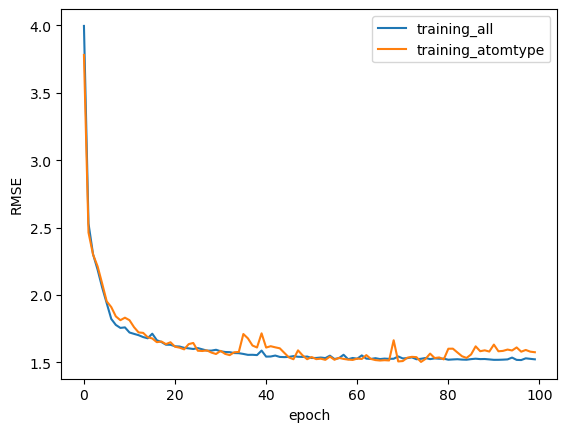

In [169]:
with open("./results/GCN_all", "rb") as f:
    results_all = pickle.load(f)
with open("./results/GCN_without_aromatic", "rb") as f:
    results_reduced = pickle.load(f)
plt.plot([i["train_loss"] for i in results_all["results"]], label="training_all")
#plt.plot([i["valid_loss"] for i in results_all["results"]], label="validation_all")
plt.plot([i["train_loss"] for i in results_reduced["results"]], label="training_atomtype")
#plt.plot([i["valid_loss"] for i in results_reduced["results"]], label="validation_atmtype")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()

In [123]:
print(results_all["time"]-results_atomtype["time"])

13.06622576713562


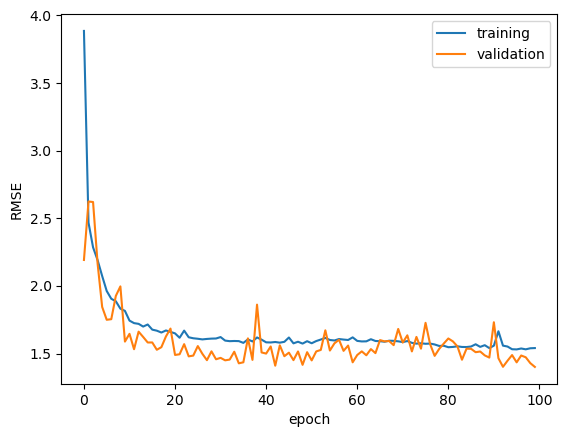

In [117]:
plt.plot([i["train_loss"] for i in results["results"]], label="training")
plt.plot([i["valid_loss"] for i in results["results"]], label="validation")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()

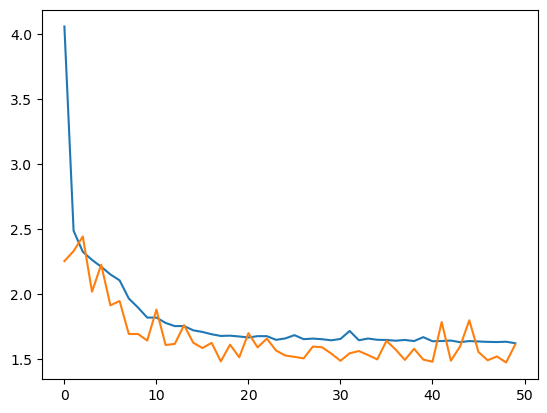

In [66]:
plt.plot([i["train_loss"] for i in results])
plt.plot([i["valid_loss"] for i in results])

In [55]:
with open("./results/GCN_all", "wb") as f:
    pickle.dump(results, f)

In [26]:
with open("./dataset_all_desc", "wb") as f:
    pickle.dump(dataset, f)

In [29]:
with open("./dataset_all_desc", "rb")  as f:
    dataset = pickle.load(f)
dataset

MyQM9(130831)

x: ノード特徴量

y: 正解ラベル

pos: 原子の座標

edge_index: エッジインデックス

edge_attr: エッジ特徴量(使えん)

ノード特徴量
type_idx: 原子の種類 
aromatic: 芳香性
sp: sp混成
sp2: sp2混成
sp3: sp3混成

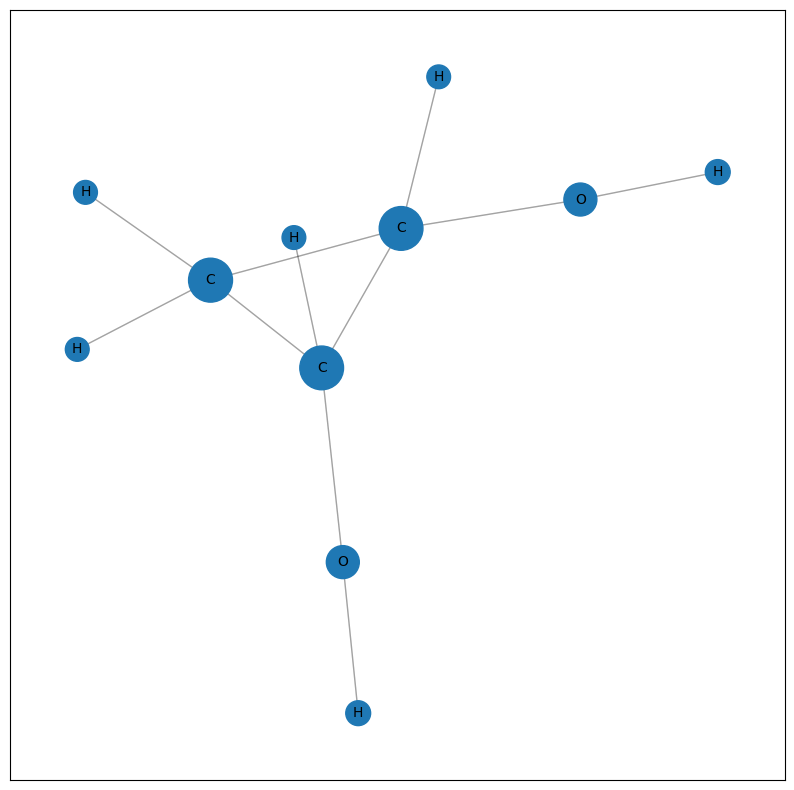

In [53]:
import networkx
from matplotlib import pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx

data = dataset[100]
nxg = to_networkx(data)

#原子番号追加
elements = {
    1:"H",
    2:"He",
    3:"Li",
    4:"Be",
    5:"B",
    6:"C",
    7:"N",
    8:"O",
    9:"F"
}
elem_labels = {}
for i in range(data.num_nodes):
    elem = elements[int(data.z[i])]
    elem_labels[i] = elem

pagerank = networkx.pagerank(nxg) #pagerankはノードの中心性(重要性の指標)
pagerank_max = np.array(list(pagerank.values())).max()

#可視化する時のノード位置
draw_position = networkx.spring_layout(nxg,seed=0)

plt.figure(figsize=(10,10))

networkx.draw_networkx_nodes(nxg,
                            draw_position,
                            node_size=[v / pagerank_max * 1000 for v in pagerank.values()]
                            )

networkx.draw_networkx_edges(nxg, draw_position, arrowstyle='-', alpha=0.2)
networkx.draw_networkx_labels(nxg, draw_position, elem_labels, font_size=10)
plt.show()

TypeError: descriptor 'max' for 'numpy.generic' objects doesn't apply to a 'str' object